In [1]:

import numpy as np
import matplotlib.pyplot as plt
from ase import Atoms
from ase.visualize import view
import os

if not os.path.exists('Polymer Chain Plots'):
    os.makedirs('Polymer Chain Plots')

# Set random seed for reproducibility
np.random.seed(42)

# ------------------------------ Function Definitions ------------------------------

# ------------------------------ MD SIMULATION -------------------------------------
def apply_pbc(position, box_size):
    """
    Apply periodic boundary conditions to keep positions within the simulation box.

    Parameters:
    position (array): Position vector of the particle.
    box_size (float): Size of the cubic simulation box.

    Returns:
    array: Position vector wrapped within the simulation box.
    """
    return position % box_size
def initialize_chain(n_particles, box_size, r0):
 """
 Initializes the positions of a polymer chain in a cubic box with periodic boundary conditions.

 Parameters:
 n_particles (int): Number of particles in the chain.
 box_size (float): Size of the simulation box.
 r0 (float): Equilibrium bond length.

 Returns:
 np.ndarray: Array of shape (n_particles, 3) containing particle positions.
 """
 positions = np.zeros((n_particles, 3))
 current_position = np.array([box_size / 2, box_size / 2, box_size / 2])
 positions[0] = current_position
 for i in range(1, n_particles):
    direction = np.random.normal(size=3)
    direction /= np.linalg.norm(direction) # Normalize to unit vector
    next_position = current_position + r0 * direction
    positions[i] = apply_pbc(next_position, box_size)
    current_position = positions[i]
 return positions

def initialize_velocities(n_particles, target_temperature, mass, k_B):
    """
    Initialize velocities for particles using a Maxwell-Boltzmann distribution.

    Parameters:
    n_particles (int): Number of particles.
    target_temperature (float): Target temperature of the system.
    mass (float): Mass of each particle.
    k_B (float): Boltzmann constant.

    Returns:
    velocities (array): Array of particle velocities in 3D space.
    """
    velocities = np.random.normal(0, np.sqrt(k_B * target_temperature / mass), (n_particles, 3))
    velocities -= np.mean(velocities, axis=0)  # Remove net momentum
    return velocities


def minimum_image(displacement, box_size):
     """
     Apply the minimum image convention to calculate the shortest displacement.

    Parameters:
    displacement (array): Displacement vector between two particles.
    box_size (float): Size of the cubic simulation box.

    Returns:
    array: Displacement vector adjusted by the minimum image convention.
    """
     return displacement - box_size * np.round(displacement / box_size)

def compute_harmonic_forces(positions, k, r0, box_size, n_particles):
    """
    Compute harmonic forces between consecutive particles in a polymer chain.

    Parameters:
    positions (array): Array of particle positions.
    k (float): Spring constant for the harmonic potential.
    r0 (float): Equilibrium bond length.
    box_size (float): Size of the cubic simulation box.
    n_particles (int): Number of particles in the system.

    Returns:
    forces (array): Array of force vectors acting on each particle.
    """
    forces = np.zeros_like(positions)
    for i in range(n_particles - 1):
        displacement = positions[i + 1] - positions[i]
        displacement = minimum_image(displacement, box_size)
        distance = np.linalg.norm(displacement)
        force_magnitude = -k * (distance - r0)
        force = force_magnitude * (displacement / distance)
        forces[i] -= force
        forces[i + 1] += force
    return forces

def compute_lennard_jones_forces(positions, epsilon, sigma, box_size, interaction_type):
    """
    Compute Lennard-Jones (LJ) forces between particles in a polymer chain, 
    taking into account specified interaction types (repulsive or attractive).

    Parameters:
    positions (array): The current positions of all particles.
    epsilon (float): The depth of the Lennard-Jones potential well.
    sigma (float): The Lennard-Jones parameter that sets the scale of particle size.
    box_size (float): The length of one edge of the cubic simulation box.
    interaction_type (str): The type of interaction to apply, either 'repulsive' or 'attractive'.

    Returns
    -------
    forces (array): The Lennard-Jones force on each particle. Each row corresponds to the force vector on a single particle.
    """
    n_particles = len(positions)
    forces = np.zeros_like(positions)
    
    for i in range(n_particles - 1):
        for j in range(i + 1, n_particles):
            if interaction_type == 'repulsive' and abs(i - j) == 2:
                epsilon_current=epsilon
            elif interaction_type == 'attractive' and abs(i - j) > 2:
                epsilon_current=epsilon
            else:
                # Neither condition for LJ interaction is met, continue to next pair
                continue
            
            displacement = positions[j] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            
            if distance < (sigma * 2**(1/6)):
                force_magnitude = 24 * epsilon_current * ((sigma / distance)**12 - 0.5 * (sigma / distance)**6) / distance
                force = force_magnitude * (displacement / distance)
                forces[i] -= force
                forces[j] += force
             
    return forces

# Velocity Verlet Integration
def velocity_verlet(positions, velocities, forces, dt, mass, k, r0, box_size, epsilon_repulsive, sigma, epsilon_attractive, n_particles, cutoff):
    """
    Perform one step of the Velocity Verlet integration for particle dynamics.

    Parameters:
    positions (array): Current particle positions.
    velocities (array): Current particle velocities.
    forces (array): Current force vectors acting on particles.
    dt (float): Time step for integration.
    mass (float): Mass of each particle.
    k (float): Spring constant for harmonic forces.
    r0 (float): Equilibrium bond length.
    box_size (float): Size of the cubic simulation box.
    epsilon_repulsive (float): Depth of the repulsive Lennard-Jones potential.
    sigma (float): Lennard-Jones parameter for particle size.
    epsilon_attractive (float): Depth of the attractive Lennard-Jones potential.
    n_particles (int): Number of particles.
    cutoff (float): Cutoff distance for Lennard-Jones interactions.

    Returns:
    tuple: Updated positions, velocities, and forces.
    """
    velocities += 0.5 * forces / mass * dt
    positions += velocities * dt
    positions = apply_pbc(positions, box_size)
    new_forces = compute_harmonic_forces(positions, k, r0, box_size, n_particles) + \
                compute_lennard_jones_forces(positions, epsilon_attractive,sigma, box_size, "attractive")+\
                 compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, "repulsive")
    velocities += 0.5 * new_forces / mass * dt
    return positions, velocities, new_forces

# Velocity Rescaling Thermostat
def rescale_velocities(velocities, target_temperature, mass, n_particles, k_B):
    """
    Rescale particle velocities to achieve the target temperature using a velocity rescaling thermostat.

    Parameters:
    velocities (array): Current particle velocities.
    target_temperature (float): Desired temperature of the system.
    mass (float): Mass of each particle.
    n_particles (int): Number of particles.
    k_B (float): Boltzmann constant.

    Returns:
    velocities (array): Rescaled particle velocities.
    """
    kinetic_energy = 0.5 * mass * np.sum(np.linalg.norm(velocities, axis=1)**2)
    current_temperature = (2 / 3) * kinetic_energy / (n_particles * k_B)
    scaling_factor = np.sqrt(target_temperature / current_temperature)
    velocities *= scaling_factor
    return velocities

# ------------------------------ ANALYSIS ----------------------------------------------------
# Analysis Functions
def calculate_radius_of_gyration(positions):
    """
    Calculate the radius of gyration for a polymer chain.

    Parameters:
    positions (array): Array of particle positions in 3D space.

    Returns:
    float: Radius of gyration of the polymer chain.
    """
    center_of_mass = np.mean(positions, axis=0)
    Rg_squared = np.mean(np.sum((positions - center_of_mass)**2, axis=1))
    return np.sqrt(Rg_squared)

def calculate_end_to_end_distance(positions):
    """
    Calculate the end-to-end distance of a polymer chain.

    Parameters:
    positions (array): Array of particle positions in 3D space.

    Returns:
    float: End-to-end distance of the polymer chain.
    """
    return np.linalg.norm(positions[-1] - positions[0])

def plot_polymer_chain(positions, temperature, save=True):
    """
    Visualize the polymer chain as beads (spheres) connected by bonds (lines).

    Parameters:
    positions (array): Array of bead positions in 3D space.
    temperature (float): Temperature of the system.
    save (bool): Whether to save the figure to a file.

    Returns:
    None
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract x, y, z coordinates of the beads
    x = positions[:, 0]
    y = positions[:, 1]
    z = positions[:, 2]

    # Plot the beads as red spheres
    ax.scatter(x, y, z, c='red', s=100, label='Beads')

    # Plot the bonds as gray lines between adjacent beads
    for i in range(len(positions) - 1):
        ax.plot([x[i], x[i + 1]], [y[i], y[i + 1]], [z[i], z[i + 1]], color='gray')

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Polymer Chain at T={temperature:.2f}')
    ax.legend()

    if save:
        filename = f'Polymer Chain Plots/polymer_chain_T_{temperature:.2f}.png'
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.close(fig)
    else:
        plt.show()

def compute_lennard_jones_potential(positions, epsilon, sigma, box_size, interaction_type):
    """
    Computes Lennard-Jones potential energy between particles in the chain.

    Parameters:
        positions (np.ndarray): Array of particle positions.
        epsilon (float): Depth of the Lennard-Jones potential well.
        sigma (float): Finite distance where the potential is zero.
        box_size (float): Size of the simulation box.
        interaction_type (str): Interaction type ('repulsive' or 'attractive').

    Returns:
        float: Lennard-Jones potential energy.
    """
    n_particles = len(positions)
    potential_energy = 0.0
    for i in range(n_particles-1):
        for j in range(i + 1, n_particles):
            displacement = positions[j] - positions[i]
            displacement = displacement - box_size * np.round(displacement / box_size)  # Minimum image convention
            distance = np.linalg.norm(displacement)
            if distance < (sigma * 2**(1/6)):
                if interaction_type == 'repulsive' and abs(i - j) == 2:
                    epsilon_current = epsilon
                    potential_energy += 4 * epsilon_current * ((sigma / distance)**12 - (sigma / distance)**6 + 0.25)
                elif interaction_type == 'attractive' and abs(i - j) > 2:
                    epsilon_current = epsilon
                    potential_energy += 4 * epsilon_current * ((sigma / distance)**12 - (sigma / distance)**6)
                else:
                    continue
            else:
                if interaction_type == 'repulsive' and abs(i - j) == 2:
                    epsilon_current = epsilon
                    potential_energy += 0
                elif interaction_type == 'attractive' and abs(i - j) > 2:
                    epsilon_current = epsilon
                    potential_energy += 4 * epsilon_current * ((sigma / distance)**12 - (sigma / distance)**6)
                else:
                    continue
    return potential_energy

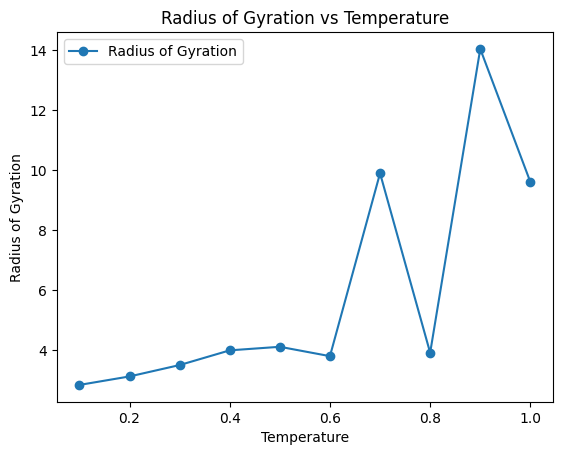

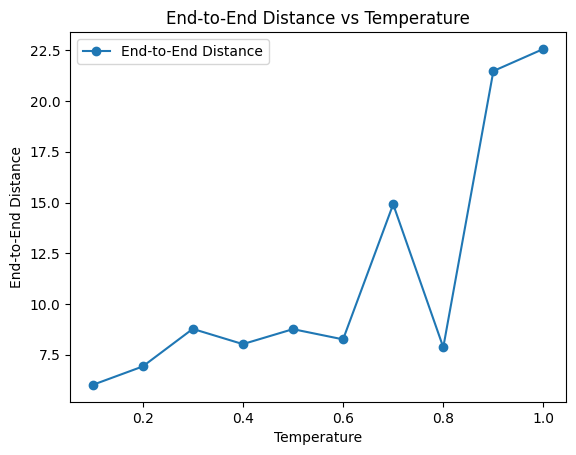

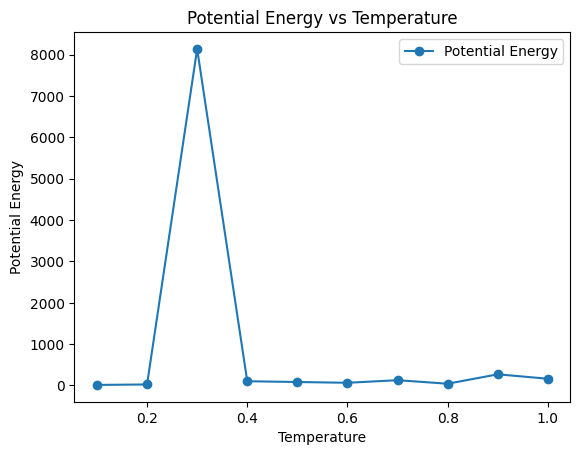

In [3]:
# ------------------------------ Main Code-No Equilibration ------------------------------


np.random.seed(42)


# Simulation parameters
dt = 0.01
total_steps = 10000
box_size = 100.0
mass = 1.0
r0 = 1.0
k = 1.0
rescale_interval = 100
n_particles = 20
epsilon_repulsive = 1.0
epsilon_attractive = 0.5
sigma = 1.0
cutoff = 2**(1/6) * sigma
k_B = 1.0

# Arrays to store results for different temperatures
temperatures = np.linspace(0.1, 1.0, 10)
mean_Rg_values = []
mean_Ree_values = []
mean_potential_energies = []
trajectories=[]

# Simulation Loop
for T in temperatures:
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, T, mass, k_B)
    
    
    Rg_values, Ree_values, potential_energies = [], [], []
    for step in range(total_steps):
        forces = compute_harmonic_forces(positions, k, r0, box_size, n_particles) + \
         compute_lennard_jones_forces(positions, epsilon_attractive,sigma, box_size, "attractive")+\
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, "repulsive")
       
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k, r0, box_size, epsilon_repulsive, sigma, epsilon_attractive, n_particles, cutoff)
       
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, T, mass, n_particles, k_B)
        
       
        Rg_values.append(calculate_radius_of_gyration(positions))
        Ree_values.append(calculate_end_to_end_distance(positions))
        trajectories.append(positions.copy())

        E_harmonic = 0.0
        for i in range(n_particles - 1):
            displacement = positions[i + 1] - positions[i]
            displacement = minimum_image(displacement, box_size)
            distance = np.linalg.norm(displacement)
            E_harmonic += 0.5 * k * (distance - r0)**2

        potential_energy_attractive=compute_lennard_jones_potential(positions, epsilon_attractive, sigma, box_size, "attractive")
        potential_energy_repulsive=compute_lennard_jones_potential(positions, epsilon_repulsive, sigma, box_size, "repulsive")
        potential_energy=potential_energy_attractive+potential_energy_repulsive+E_harmonic
        potential_energies.append(potential_energy)
            
       
      
        if step == total_steps - 1:  # Plot only after the last step of simulation
            plot_polymer_chain(positions, T, save=True)
                

    mean_Rg_values.append(np.mean(Rg_values))
    mean_Ree_values.append(np.mean(Ree_values))
    mean_potential_energies.append(np.mean(potential_energies))

# Plot Results
plt.figure()
plt.plot(temperatures, mean_Rg_values, 'o-', label='Radius of Gyration')
plt.xlabel('Temperature')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.plot(temperatures, mean_Ree_values, 'o-', label='End-to-End Distance')
plt.xlabel('Temperature')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.plot(temperatures, mean_potential_energies, 'o-', label='Potential Energy')
plt.xlabel('Temperature')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Temperature')
plt.legend()
plt.show()

Trajectories 0.10 saved to: Trajectories\trajectories_0.10.npy
Trajectories 0.20 saved to: Trajectories\trajectories_0.20.npy
Trajectories 0.30 saved to: Trajectories\trajectories_0.30.npy
Trajectories 0.40 saved to: Trajectories\trajectories_0.40.npy
Trajectories 0.50 saved to: Trajectories\trajectories_0.50.npy
Trajectories 0.60 saved to: Trajectories\trajectories_0.60.npy
Trajectories 0.70 saved to: Trajectories\trajectories_0.70.npy
Trajectories 0.80 saved to: Trajectories\trajectories_0.80.npy
Trajectories 0.90 saved to: Trajectories\trajectories_0.90.npy
Trajectories 1.00 saved to: Trajectories\trajectories_1.00.npy


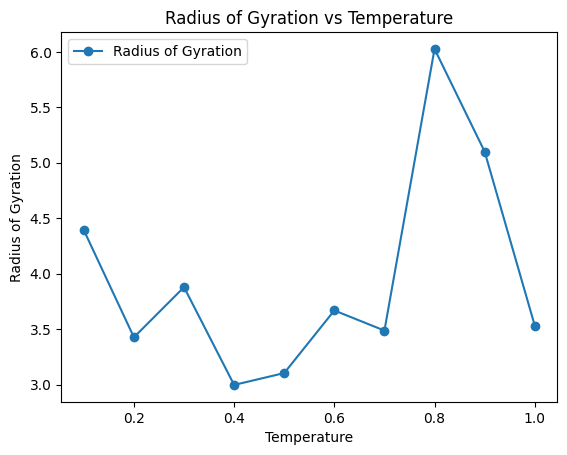

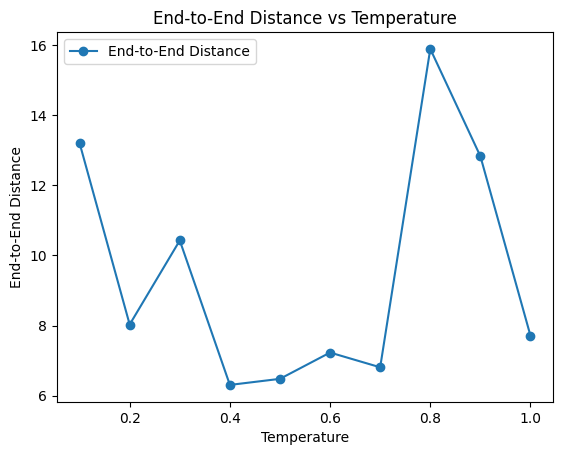

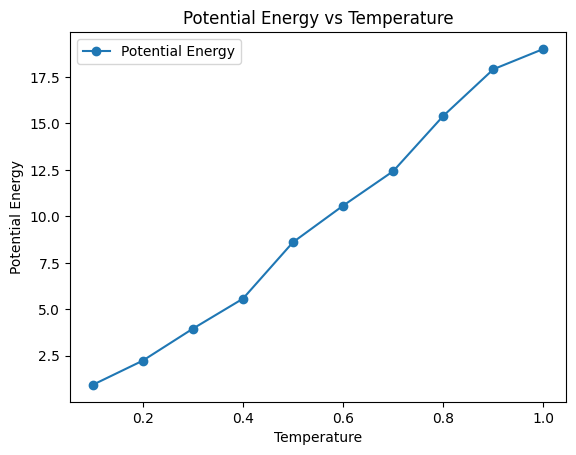

In [ ]:
# ------------------------------ Main Code-USING EQUILIBRAITON ------------------------------


np.random.seed(42)
trajectory_dir = 'Trajectories'
if not os.path.exists(trajectory_dir):
    os.makedirs(trajectory_dir)


# Simulation parameters
dt = 0.01
total_steps = 55000
box_size = 100.0
mass = 1.0
r0 = 1.0
k = 1.0
rescale_interval = 100
n_particles = 20
epsilon_repulsive = 1.0
epsilon_attractive = 0.5
sigma = 1.0
cutoff = 2**(1/6) * sigma
k_B = 1.0

# Arrays to store results for different temperatures
temperatures = np.linspace(0.1, 1.0, 10)
mean_Rg_values = []
mean_Ree_values = []
mean_potential_energies = []
trajectories=[]

# Simulation Loop
for T in temperatures:
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, T, mass, k_B)
    
    
    Rg_values, Ree_values, potential_energies = [], [], []
    for step in range(total_steps):
        #Compute forces
        forces = compute_harmonic_forces(positions, k, r0, box_size, n_particles) + \
         compute_lennard_jones_forces(positions, epsilon_attractive,sigma, box_size, "attractive")+\
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, "repulsive")
       
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k, r0, box_size, epsilon_repulsive, sigma, epsilon_attractive, n_particles, cutoff)
       #Rescale velocities
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, T, mass, n_particles, k_B)
        
        if step >=53000:  #Apply equilibration
            Rg_values.append(calculate_radius_of_gyration(positions))
            Ree_values.append(calculate_end_to_end_distance(positions))
            trajectories.append(positions.copy())

            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2

    #Compute the potential Energy
            potential_energy_attractive=compute_lennard_jones_potential(positions, epsilon_attractive, sigma, box_size, "attractive")
            potential_energy_repulsive=compute_lennard_jones_potential(positions, epsilon_repulsive, sigma, box_size, "repulsive")
            potential_energy=potential_energy_attractive+potential_energy_repulsive+E_harmonic
            potential_energies.append(potential_energy)
            
       
      
            if step == total_steps - 1:  # Plot only after the last step of simulation
                plot_polymer_chain(positions, T, save=True)
                trajectory_file_path = os.path.join(trajectory_dir, f"trajectories_{T:.2f}.npy")
                np.save(trajectory_file_path, trajectories)
                print(f"Trajectories {T:.2f} saved to: {trajectory_file_path}")

      
#Calculate average of the values
    mean_Rg_values.append(np.mean(Rg_values))
    mean_Ree_values.append(np.mean(Ree_values))
    mean_potential_energies.append(np.mean(potential_energies))

# Plot Results
plt.figure()
plt.plot(temperatures, mean_Rg_values, 'o-', label='Radius of Gyration')
plt.xlabel('Temperature')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.plot(temperatures, mean_Ree_values, 'o-', label='End-to-End Distance')
plt.xlabel('Temperature')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Temperature')
plt.legend()
plt.show()

plt.figure()
plt.plot(temperatures, mean_potential_energies, 'o-', label='Potential Energy')
plt.xlabel('Temperature')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Temperature')
plt.legend()
plt.show()

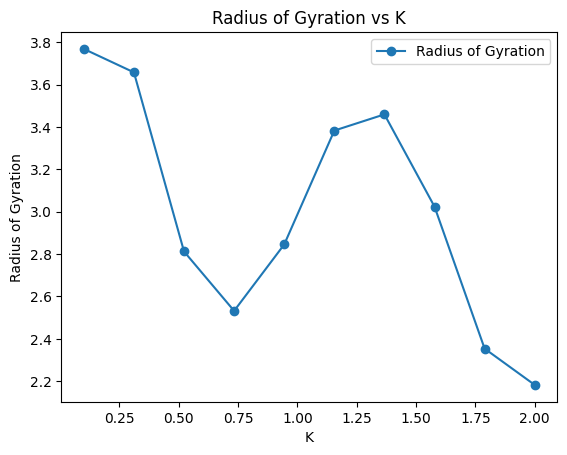

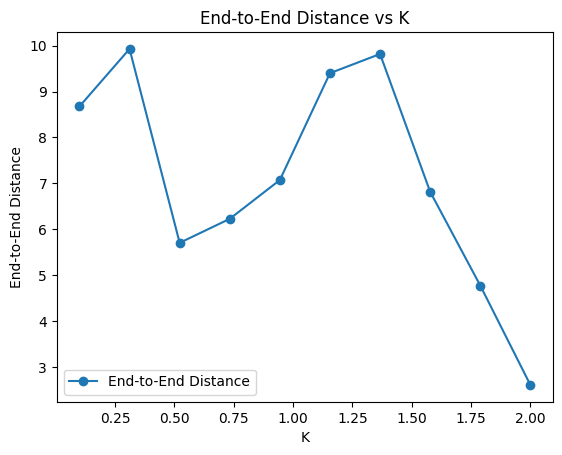

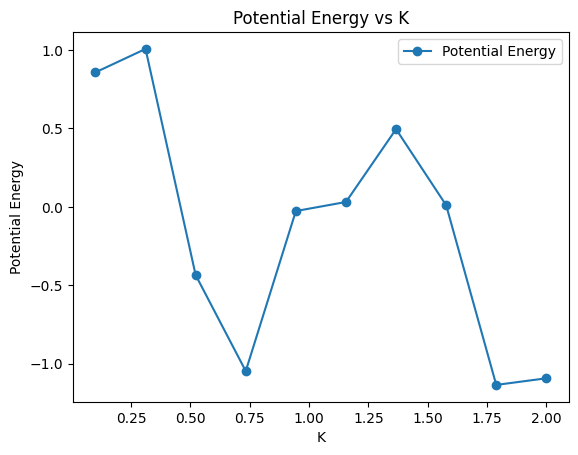

In [29]:
# ------------------------------ Main Code-K dependence------------------------------

# Simulation parameters
dt = 0.01
total_steps = 55000
box_size = 100.0
mass = 1.0
r0 = 1.0
k_vals = np.linspace(0.1,2, 10)
rescale_interval = 100
n_particles = 20
epsilon_repulsive = 1.0
epsilon_attractive = 0.5
sigma = 1.0
cutoff = 2**(1/6) * sigma
k_B = 1.0
np.random.seed(42)
# Arrays to store results for different temperatures

mean_Rg_values = []
mean_Ree_values = []
mean_potential_energies = []

# Simulation Loop
for k in k_vals:
    T=0.1
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, T, mass, k_B)
    
    
    Rg_values, Ree_values, potential_energies = [], [], []
    for step in range(total_steps):
        forces = compute_harmonic_forces(positions, k, r0, box_size, n_particles) + \
         compute_lennard_jones_forces(positions, epsilon_attractive,sigma, box_size, "attractive")+\
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, "repulsive")
       
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k, r0, box_size, epsilon_repulsive, sigma, epsilon_attractive, n_particles, cutoff)
       
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, T, mass, n_particles, k_B)
        
        if step >=53000:
            Rg_values.append(calculate_radius_of_gyration(positions))
            Ree_values.append(calculate_end_to_end_distance(positions))

            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2
    
            potential_energy_attractive=compute_lennard_jones_potential(positions, epsilon_attractive, sigma, box_size, "attractive")
            potential_energy_repulsive=compute_lennard_jones_potential(positions, epsilon_repulsive, sigma, box_size, "repulsive")
            potential_energy=potential_energy_attractive+potential_energy_repulsive+E_harmonic
            potential_energies.append(potential_energy)
      

    mean_Rg_values.append(np.mean(Rg_values))
    mean_Ree_values.append(np.mean(Ree_values))
    mean_potential_energies.append(np.mean(potential_energies))

# Plot Results
plt.figure()
plt.plot(k_vals, mean_Rg_values, 'o-', label='Radius of Gyration')
plt.xlabel('K')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs K')
plt.legend()
plt.show()

plt.figure()
plt.plot(k_vals, mean_Ree_values, 'o-', label='End-to-End Distance')
plt.xlabel('K')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs K')
plt.legend()
plt.show()

plt.figure()
plt.plot(k_vals, mean_potential_energies, 'o-', label='Potential Energy')
plt.xlabel('K')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs K')
plt.legend()
plt.show()

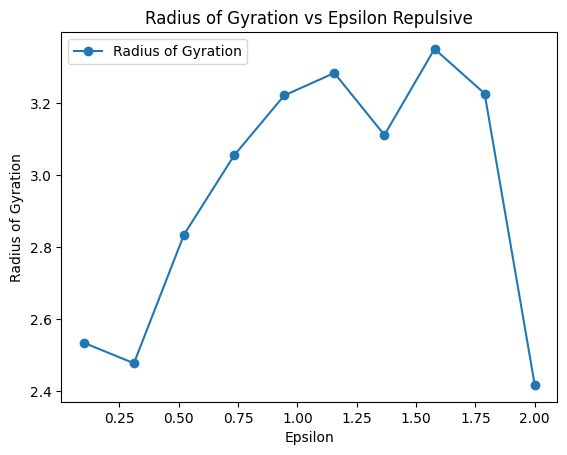

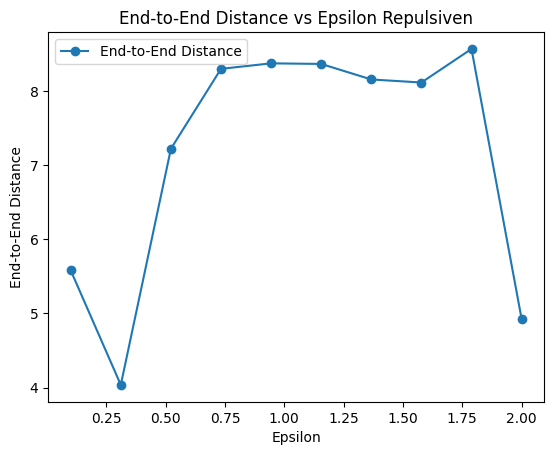

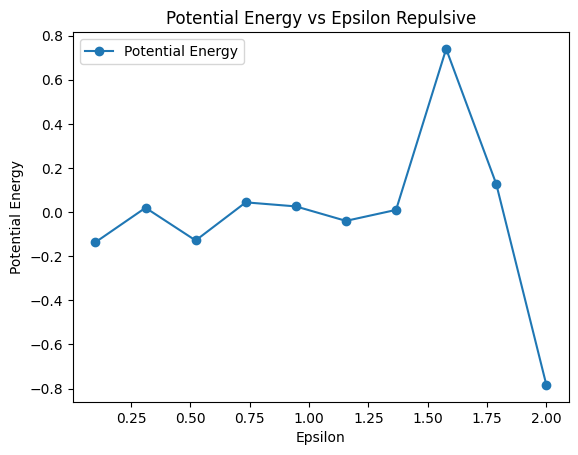

In [30]:
# ------------------------------ Main Code-Repulsive interactions dependence ------------------------------

# Simulation parameters
dt = 0.01
total_steps = 55000
box_size = 100.0
mass = 1.0
r0 = 1.0
k = 1
rescale_interval = 100
n_particles = 20
epsilon_repulsive_vals = np.linspace(0.1,2, 10)
epsilon_attractive = 0.5
sigma = 1.0
cutoff = 2**(1/6) * sigma
k_B = 1.0
np.random.seed(42)
# Arrays to store results for different temperatures

mean_Rg_values = []
mean_Ree_values = []
mean_potential_energies = []

# Simulation Loop
for epsilon_repulsive in epsilon_repulsive_vals:
    T=0.1
    positions = initialize_chain(n_particles, box_size, r0)
    velocities = initialize_velocities(n_particles, T, mass, k_B)
    
    Rg_values, Ree_values, potential_energies = [], [], []
    for step in range(total_steps):
         
        forces = compute_harmonic_forces(positions, k, r0, box_size, n_particles) + \
         compute_lennard_jones_forces(positions, epsilon_attractive,sigma, box_size, "attractive")+\
         compute_lennard_jones_forces(positions, epsilon_repulsive, sigma, box_size, "repulsive")
       
        positions, velocities, forces = velocity_verlet(positions, velocities, forces, dt, mass, k, r0, box_size, epsilon_repulsive, sigma, epsilon_attractive, n_particles, cutoff)
       
        if step % rescale_interval == 0:
            velocities = rescale_velocities(velocities, T, mass, n_particles, k_B)
        
        if step >=53000:
            Rg_values.append(calculate_radius_of_gyration(positions))
            Ree_values.append(calculate_end_to_end_distance(positions))

            E_harmonic = 0.0
            for i in range(n_particles - 1):
                displacement = positions[i + 1] - positions[i]
                displacement = minimum_image(displacement, box_size)
                distance = np.linalg.norm(displacement)
                E_harmonic += 0.5 * k * (distance - r0)**2
    
            potential_energy_attractive=compute_lennard_jones_potential(positions, epsilon_attractive, sigma, box_size, "attractive")
            potential_energy_repulsive=compute_lennard_jones_potential(positions, epsilon_repulsive, sigma, box_size, "repulsive")
            potential_energy=potential_energy_attractive+potential_energy_repulsive+E_harmonic
            potential_energies.append(potential_energy)
      

    mean_Rg_values.append(np.mean(Rg_values))
    mean_Ree_values.append(np.mean(Ree_values))
    mean_potential_energies.append(np.mean(potential_energies))

# Plot Results
plt.figure()
plt.plot(epsilon_repulsive_vals, mean_Rg_values, 'o-', label='Radius of Gyration')
plt.xlabel('Epsilon')
plt.ylabel('Radius of Gyration')
plt.title('Radius of Gyration vs Epsilon Repulsive')
plt.legend()
plt.show()

plt.figure()
plt.plot(epsilon_repulsive_vals, mean_Ree_values, 'o-', label='End-to-End Distance')
plt.xlabel('Epsilon')
plt.ylabel('End-to-End Distance')
plt.title('End-to-End Distance vs Epsilon Repulsiven')
plt.legend()
plt.show()

plt.figure()
plt.plot(epsilon_repulsive_vals, mean_potential_energies, 'o-', label='Potential Energy')
plt.xlabel('Epsilon')
plt.ylabel('Potential Energy')
plt.title('Potential Energy vs Epsilon Repulsive')
plt.legend()
plt.show()